# Data Science From Scratch Notes

## Chapter 6: Probability

## Dependence and Independence

Two events A and B are *dependent* if knowing something about whether A happens gives us information about whether B happens and vice versa. Otherwise, they are *independent*.

Mathematically, we say two events are independent if the probability that they both happen is the product of the probabilities that each one happens:

$$P(A \cap B) = P(A)P(B)$$

## Conditional Probability

If two events are dependent, the conditional probability is:

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

If events A and B are independent:

$$P(A|B) = P(A)$$

With a family of two children, what is the probability both children are girls given the older child is a girl? 

If event B is "both children are girls", and event G is "the older child is a girl":

$$P(B|G) = \frac{P(B \cap G)}{P(G)} = \frac{P(B)}{P(G)} = \frac{1/4}{1/2} = \frac{1}{2}$$

What is the probability both children are girls given at least one of the children is a girl?

If event L is "at least one of the children is a girl":

$$P(B|L) = \frac{P(B \cap L)}{P(L)} = \frac{P(B)}{P(L)} = \frac{1/4}{3/4} = \frac{1}{3}$$

Let's check these with some simulation code:

In [1]:
import enum, random

# An Enum is a typed set of enumerated values. We can use them
# to make our code more descriptive and readable.
class Kid(enum.Enum):
    BOY = 0
    GIRL = 1
    
def random_kid() -> Kid:
    return random.choice([Kid.BOY, Kid.GIRL])

both_girls = 0
older_girl = 0
either_girl = 0

random.seed(0)

for _ in range(10000):
    younger = random_kid()
    older = random_kid()
    if older == Kid.GIRL:
        older_girl += 1
    if older == Kid.GIRL and younger == Kid.GIRL:
        both_girls += 1
    if older == Kid.GIRL or younger == Kid.GIRL:
        either_girl += 1

print("P(both | older): ", both_girls / older_girl) # ~ 1/2
print("P(both | either): ", both_girls / either_girl) # ~ 1/3

P(both | older):  0.5007089325501317
P(both | either):  0.3311897106109325


## Bayes' Theorem

$$P(A|B) = \frac{P(B|A)P(A)}{P(B|A)P(A) + P(B| \lnot{A})P(\lnot{A})}$$

## Random Variables

A variable whose possible values have an associated probability distribution.

The *expected value* of a random varialbe is the average of its values weighted by their probabilities.

## Continuous Distributions

A coin flip corresponds to a *discrete distribution*. A continuous distribution is one that contains a continuum of outcomes. We represent continuous distributions with a *probability density function* such that the probability of seeing a value in a certain interval equals the integral of the density function over the interval.

The PDF for the uniform distribution is:

In [2]:
def uniform_pdf(x: float) -> float:
    return 1 if 0 <= x < 1 else 0

A *cumulative density function* (CDF) gives the probability that a random variable is less than or equal to a certain value. The CDF for the uniform distribution is:

In [3]:
def uniform_cdf(x: float) -> float:
    """Returns the probability that a uniform random variable is <= x"""
    if x < 0: return 0 # uniform random is never less than 0
    elif x < 1: return x # e.g. P(X <= 0.4) = 0.4
    else: return 1 # uniform random is always less than 1

## The Normal Distribution

The normal distribution has two parameters: its mean $\mu$ and its standard deviation $\sigma$. It has the PDF:

$$f(x| \mu, \sigma) = \frac{ 1}{\sqrt{ 2 \pi} \sigma}\exp{\biggr(-\frac{(x - \mu)^2}{ 2 \sigma ^2}\biggl)}$$

We can implement this as:

In [5]:
import math
SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return(math.exp(-(x-mu) ** 2 / (2 * (sigma ** 2))) / (SQRT_TWO_PI * sigma))

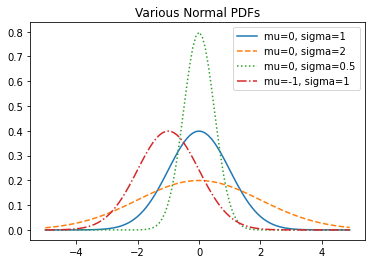

In [8]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_pdf(x, sigma=1) for x in xs], '-', label='mu=0, sigma=1')
plt.plot(xs, [normal_pdf(x, sigma=2) for x in xs], '--', label='mu=0, sigma=2')
plt.plot(xs, [normal_pdf(x, sigma=0.5) for x in xs], ':', label='mu=0, sigma=0.5')
plt.plot(xs, [normal_pdf(x, mu=-1) for x in xs], '-.', label='mu=-1, sigma=1')
plt.legend()
plt.title("Various Normal PDFs")
plt.show()

The CDF for the normal distribution can be written with Python's `math.erf` error function:

In [11]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return(1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

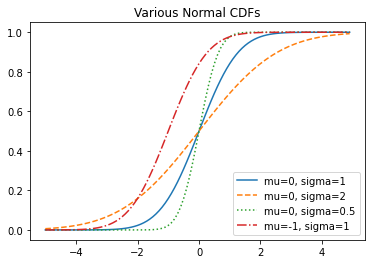

In [12]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs], '-', label='mu=0, sigma=1')
plt.plot(xs, [normal_cdf(x, sigma=2) for x in xs], '--', label='mu=0, sigma=2')
plt.plot(xs, [normal_cdf(x, sigma=0.5) for x in xs], ':', label='mu=0, sigma=0.5')
plt.plot(xs, [normal_cdf(x, mu=-1) for x in xs], '-.', label='mu=-1, sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal CDFs")
plt.show()

Sometimes, we need to invert `normal_cdf` to find the value corresponding to a specified probability. There's no simple way to compute its inverse, but `normal_cdf` is continuous and monotonically increasing, so we can use a *binary search*:

In [13]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""
    
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance = tolerance)
    
    low_z = -10.0 # normal_cdf(-10) is (very close to) 0
    hi_z = 10.0 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # Consider the midpoint
        mid_p = normal_cdf(mid_z) # and the CDF's value there
        if mid_p < p:
            low_z = mid_z # Midpoint too low, search abov it
        else:
            hi_z = mid_z # Midpoint too high, search below it
            
    return mid_z

The function repeatedly bisects intervals until it narrows in on a Z that's close enough to the desired probability.

## The Central Limit Theorem

A random variable defined as the average of a large number of independent and identically distributed random variables is itself approximately normally distributed.

If $x_1, \ldots, x_n$ are random variables with mean $\mu$ and standard deviation $\sigma$, and if *n* is large, then:

$$\frac{1}{n} (x_1 + \ldots + x_n)$$

is approximately normally distributed with mean $\mu$ and standard deviation $\frac{\sigma}{\sqrt{n}}$.

Equivalently:

$$\frac{(x_1 + \ldots + x_n) - \mu n}{\frac{\sigma}{\sqrt{n}}}$$

is approximately normally distributed with mean 0 and standard deviation 1.

Let's illustrate this with *binomial* random variables, which have two parameters *n* and *p*. The Binomial(n,p) random variable is the sum of *n* independent Bernoulli(p) random variables, each of which equals 1 with probability *p* and 0 with probability $1-p$:

In [14]:
def bernoulli_trial(p: float) -> int:
    """Returns 1 with probability p and 0 with probability 1-p"""
    return 1 if random.random() < p else 0

def binomial(n: int, p: float) -> int:
    """Returns the sum of n bernoulli(p) trials"""
    return sum(bernoulli_trial(p) for _ in range(n))

The mean of a Bernoulli(p) variable is *p*, and its standard deviation is $\sqrt{p(1-p)}$. The central limit theorm says that as *n* gets large, a Binomial(n,p) variable is approximately a normal random variable with mean $\mu = np$ and standard deviation $\sigma = \sqrt{np(1-p)}$. Let's plot both:

In [18]:
from collections import Counter

def binomial_histogram(p: float, n: int, num_points) -> None:
    """Picks points from a Binomial(n,p) and plots their histogram"""
    data = [binomial(n, p) for _ in range(num_points)]
    
    # use a bar chart to show the actual binomial samples
    histogram = Counter(data)
    plt.bar([x - 0.4 for x in histogram.keys()],
            [v / num_points for v in histogram.values()],
            0.8,
            color='0.75')
    
    mu = n * p
    sigma = math.sqrt(n * p * (1 - p))
    
    # use a line chart to show the normal approximation
    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma)
          for i in xs]
    plt.plot(xs, ys)
    plt.title("Binomial Distribution vs. Normal Approximation")
    plt.show()

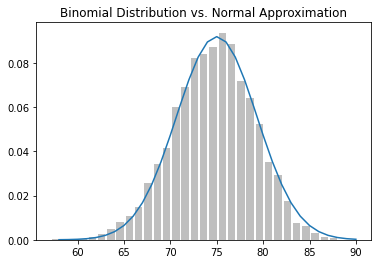

In [19]:
binomial_histogram(0.75, 100, 10000)